In [1]:
import numpy as np
import numdifftools as nd
from collections.abc import Iterable, Callable
from matplotlib import pyplot as plt 
import time

## Task 1

Зададим функцию, производные которой будем оценивать:
$$f(x_1, x_2, \dotsc, x_n) = \sum_{i=1}^n \frac{\frac{1}{x_i^5} + \frac{3^{x_i}}{10} - \ln(|x_i|)}{-x_i}$$

In [2]:
def example_func(x: Iterable) -> float:
    return np.sum((1 / np.power(x, 5) + np.power(3, x) / 10 - np.log(x)) / np.negative(x))

Функция нахождения производных функции методом конечных разностей

In [3]:
def derivatives_finite_difference(f: Callable, x: np.ndarray[float], h: float) -> np.ndarray[float]:
    f0 = f(x)
    derivatives = [0.0] * len(x)
    for i in range(len(x)):
        x[i] += h
        derivatives[i] = (f(x) - f0) / h
        x[i] -= h
    return np.array(derivatives)

Функция нахождения производных функции методом комплексного приращения

In [4]:
def derivatives_complex_step(f: Callable, x: np.ndarray[float], h: float) -> np.ndarray[float]:
    x = np.array(x, dtype=complex)
    derivatives = [0.0] * len(x)
    for i in range(len(x)):
        x[i] += 1j * h
        derivatives[i] = f(x).imag / h
        x[i] -= 1j * h
    return np.array(derivatives)

Возьмём готовую реализацию автоматического дифференцирования из `numdifftools`

In [5]:
def derivatives_automatic(f: Callable, x: np.ndarray[float], h: float = 0) -> np.ndarray[float]:
    return np.array(nd.Gradient(f)(x))

Посмотрим при различных $h$ что мы получим каждым методом

In [6]:
METHODS = {'finite differences': derivatives_finite_difference,
           'complex-step': derivatives_complex_step,
           'automatic': derivatives_automatic}
max_len = len(max(METHODS.keys(), key=len))
HS = np.power(10.0, range(-300, 1))
X = np.ones(200) * 2
results = {}
for method_name, method_function in METHODS.items():
    start_time = time.time()
    print(f"{method_name.upper()}:", ' ' * (max_len - len(method_name)), end='')
    results_for_method = []
    for h in HS:
        derivatives = method_function(example_func, X, h)
        results_for_method.append(derivatives[0])

    results[method_name] = results_for_method
    print(f"{(time.time() - start_time):.3f}s")

FINITE DIFFERENCES: 0.942s
COMPLEX-STEP:       1.906s
AUTOMATIC:          32.289s


Как видно, автоматическое дифференцирование оказалось значительно дольше остальных методов.

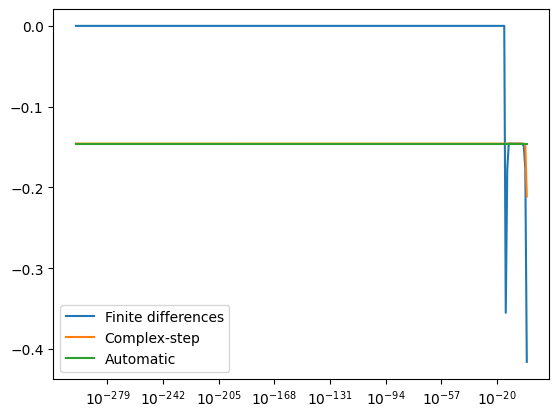

In [7]:
NUM_METHODS = len(METHODS.keys())
for method_id, method_name in enumerate(METHODS.keys()):
    plt.plot(HS, results[method_name], label=method_name.capitalize())
    plt.gca().set_xscale('log')
plt.legend()
plt.show()

Найдём наследственную ошибку нашей функции методом линеаризации, применяя в нём наши  методы оценки производных

In [8]:
def linearization_error_estimate(x: Iterable,
                                 deltas: Iterable,
                                 func: Callable,
                                 derivatives_estimator: Callable,
                                 h: float,
                                 *args) -> float | np.ndarray[float]:
    derivatives = derivatives_estimator(func, x, h, *args)
    A = np.matrix(np.abs(derivatives))
    if A.shape[0] == 1:
        return np.sum(np.multiply(derivatives, deltas))
    else:
        return np.array(A.T @ deltas)[0]

In [9]:
ERROR_PERCENT = 0.1
deltas = np.multiply(X, ERROR_PERCENT / 100)
for method_name, method_function in METHODS.items():
    error = linearization_error_estimate(X, deltas, example_func, method_function, h=10**-10)
    print(f"Linearization error estimate using the {method_name} method is ", ' ' * (max_len - len(method_name)) ,error, sep='')

Linearization error estimate using the finite differences method is -0.058321347751189016
Linearization error estimate using the complex-step method is       -0.058314930016254214
Linearization error estimate using the automatic method is          -0.05831493001606286
